In [21]:
%matplotlib inline

In [2]:
"""Train classifier on HAM10000 dataset.
"""

import os

import sys

sys.path.append("..")

import time

import datetime

import logging

import argparse

from tqdm import tqdm

import matplotlib

import PIL

matplotlib.use('agg')

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import numpy as np

# Torch stuff
import torch.optim as optim
import torch.nn as nn

# from torch.utils.data.sampler import RandomSampler
from torch.utils.data.dataloader import DataLoader

from torch.utils.data import WeightedRandomSampler

from torch.utils.tensorboard import SummaryWriter

import torch
# import torch.backends.cudnn as cudnn

# Network options
from networks.SimpleCNN import SimpleCNN

from torchvision.models.vgg import vgg16
from torchvision.models.alexnet import alexnet
from torchvision.models.resnet import (
    resnet50, resnet34, resnet101, resnet152)

import torchvision.transforms as transforms

# Experiment specific imports
from lib.dataset import create_train_val_split, HAM10000

from lib.utils import (
    setup_logging, save_checkpoint, create_loss_plot, cm2df,
    produce_per_class_stats)

# Collect constants in separate file, C headers style.
import constants

In [4]:
# Training.
def train(net, train_loader, criterion, optimizer,
          batch_size, device, epoch, logger, writer, exp_dir):
    """Performs training for one epoch
    """

    # TODO move in arguments
    # print message only every N batches
    print_every = 50

    logger.info('Epoch: {}'.format(epoch + 1))

    net.train()

    train_loss = 0
    correct = 0
    total = 0

    # Needs to be changed because of the DL sampler
    # n_batches = len(train_loader.dataset) // batch_size
    n_batches = len(train_loader)

    all_targets = np.array([], dtype=int)
    all_predicted = np.array([], dtype=int)

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # Send tensors to the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)

        # Set gradients to 0
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backprop
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)

        total += targets.size(0)

        correct += predicted.eq(targets).sum().item()

        if (batch_idx + 1) % print_every == 0:

            # Compute accuracy
            acc = 100.*correct/total

            logger.info(constants.STATUS_MSG.format(
                batch_idx+1,
                n_batches,
                train_loss/(batch_idx+1),
                acc))

        # TODO add this to parameter
        if (epoch + 1) % 10 == 0:
            # Save all for confusion matrix
            all_targets = np.hstack(
                (all_targets, targets.cpu().numpy().astype(int)))

            all_predicted = np.hstack(
                (all_predicted, predicted.cpu().numpy().astype(int)))

    # TODO add this to parameter
    if (epoch + 1) % 10 == 0:
        # Display confusion matrix
        cm = confusion_matrix(all_targets, all_predicted)

        # Save confusion matrix
        np.save(os.path.join(exp_dir, "confusion_matrix_train_latest.npy"), cm)

        # Get detailed stats per class
        stats_per_class = produce_per_class_stats(
            all_targets, all_predicted, train_loader.dataset.class_map_dict)

        # Add scalars corresponding to these metrics to tensorboard
        for score in ['precision_score', 'recall_score',
                      'roc_auc_score']:
            for k in train_loader.dataset.class_map_dict:
                # Add scalars to tb
                writer.add_scalar(
                    "{}_{}_train".format(k, score),
                    stats_per_class[k][score],
                    epoch)

        cm_pretty = cm2df(cm, train_loader.dataset.class_map_dict)

        # Compute balanced accuracy
        bal_acc = balanced_accuracy_score(all_targets, all_predicted)

        writer.add_scalar("balanced_accuracy/train", bal_acc, epoch)

        print(cm_pretty)

    # Add accuracy on validation set to tb
    writer.add_scalar("accuracy/train", acc, epoch)

    return train_loss/(batch_idx+1), acc

In [5]:
def test(net, val_loader, criterion,
         batch_size, device, epoch, logger, writer, exp_dir, best_acc):
    """
    Performs inference on the validation set

    Parameters
    ----------

    net : nn.Module
        The object representing the network.

    val_loader : torch.utils.data.DataLoader
        The dataloader for the validation set.

    criterion : torch.nn.modules.loss._Loss
        The object representing the loss function.

    batch_size : int

    device : str
        Either 'cpu' or 'cuda', depending on the backend used for computation.

    epoch : int
        The number of the current epoch.

    logger : logging.Logger

    writer : torch.utils.tensorboard.SummaryWriter
        The object used to write Tensorboard events.

    exp_dir : str
        The folder where experiment results (model and log) are saved.

    best_acc : float
        The best value for the accuracy so far obtained with the model.

    Returns
    -------

    float
        The loss computed on the validation set at current epoch.

    float
        The accuracy of the model on the validation set at current epoch.

    float
        The best value for the accuracy so far obtained with the model.

    return test_loss/(batch_idx+1), acc, best_acc
    """

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    n_batches = len(val_loader.dataset) // batch_size

    all_targets = np.array([], dtype=int)
    all_predicted = np.array([], dtype=int)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(
                enumerate(val_loader), total=n_batches):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)

            # TODO probably should throw away this stuff here
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Save all for confusion matrix
            all_targets = np.hstack(
                (all_targets, targets.cpu().numpy().astype(int)))

            all_predicted = np.hstack(
                (all_predicted, predicted.cpu().numpy().astype(int)))

    # Display confusion matrix
    cm = confusion_matrix(all_targets, all_predicted)

    # Save confusion matrix
    np.save(os.path.join(exp_dir, "confusion_matrix_test_latest.npy"), cm)

    # Get detailed stats per class
    stats_per_class = produce_per_class_stats(
        all_targets, all_predicted, val_loader.dataset.class_map_dict)

    # Add scalars corresponding to these metrics to tensorboard
    for score in ['precision_score', 'recall_score', 'roc_auc_score']:
        for k in val_loader.dataset.class_map_dict:
            # Add scalars to tb
            writer.add_scalar(
                "{}_{}_val".format(k, score),
                stats_per_class[k][score],
                epoch)

    cm_pretty = cm2df(cm, val_loader.dataset.class_map_dict)

    print(cm_pretty)

    # Save checkpoint.
    acc = 100.*correct/total
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }

    # Add accuracy on validation set to tb
    writer.add_scalar("accuracy/val", acc, epoch)

    # Compute balanced accuracy
    bal_acc = balanced_accuracy_score(all_targets, all_predicted)

    writer.add_scalar("balanced_accuracy/val", bal_acc, epoch)

    # Display accuracy
    logger.info("Accuracy on validation set after epoch {}: {}".format(
        epoch+1, acc))

    if acc > best_acc:
        logger.info('Saving..')
        save_checkpoint(state, exp_dir, backup_as_best=True)
        best_acc = acc
    else:
        save_checkpoint(state, exp_dir, backup_as_best=False)

    return test_loss/(batch_idx+1), acc, best_acc

In [ ]:
def get_data_augmentation_transforms(level, normalize_input=False):
    """Returns the list of transforms to be applied to the a dataset,
       for data augmentation.

    Parameters
    ----------

    level : int
        The level of data augmentation applied.
        0: no data augmentation (just transform to tensor using
        transforms.ToTensor())
        1: horizontal/vertical flips, chance 0.5
        2: random resized crops, chance 0.5
        3: alter the color space of images, chance 0.5

    normalize_input : bool, optional
        Wether to normalize the input by subtracting mean and dividing by
        standard deviation, so that values lie in the -1, 1 interval. The
        default is `False`.

    Returns
    -------

    transforms : torchvision.transforms
        The transforms that are applied to each data point.

    """

    # Keep this as an example
    # transform = transforms.Compose([
        # transforms.Resize(256),
        # transforms.RandomCrop(224),
        # transforms.RandomHorizontalFlip(),
        # transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # First create the list of transforms, add each one individually (for
    # better code readability), then return a composition of all the
    # transforms.

    transforms_list = list()

    # Slightly change colors
    if level >= 3:
        colorjitter_transform = transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2)
        transforms_list.append(transforms.RandomApply(
            [colorjitter_transform], 0.5))

    # Horizontal/vertical flip with 0.5 chance
    if level >= 4:
        rotation_transform = transforms.RandomRotation(
            20, resample=PIL.Image.BILINEAR)
        transforms_list.append(
            transforms.RandomApply([rotation_transform], p=0.5))

    # A random resized crop
    if level >= 2:
        crop_transform = transforms.RandomResizedCrop(
            (450, 600), scale=(0.8, 1.0), ratio=(1, 1))
        transforms_list.append(
            transforms.RandomApply([crop_transform], p=0.5))

    # Horizontal/vertical flip with 0.5 chance
    if level >= 1:
        transforms_list.append(transforms.RandomHorizontalFlip(0.5))
        transforms_list.append(transforms.RandomVerticalFlip(0.5))

    transforms_list.append(transforms.ToTensor())

    # Add normalization?
    if normalize_input:
        transforms_list.append(transforms.Normalize(
            constants.NORMALIZATION_MEAN,
            constants.NORMALIZATION_STD))

    return transforms.Compose(transforms_list)

In [12]:
# Create args manually
class MyArgs:
    pass

args = MyArgs()

args.data_dir = "../data"

args.train_fraction = 0.8

args.val_fraction = 0.2

args.exp_name = "lr_finder"

args.log_level = "INFO"

args.data_augmentation_level = 3

args.batch_size = 8

args.lr = 1e-7

args.weight_decay = 1e-4

args.class_weights = [2.5, 2.5, 2.5, 2.5, 2, 1, 2]

args.network = "resnet50"

args.use_pretrained = True

args.num_epochs = 100

args.normalize_input = True

args.optimizer = "Adam"

args.resume = False

In [14]:
#     exp_dir = os.path.join('experiments', '{}'.format(args.exp_name))

#     os.makedirs(exp_dir, exist_ok=True)

logger = logging.getLogger()

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    logger.info('==> CUDA available, Running on GPU :)')
else:
    device = 'cpu'
    logger.info('==> CUDA unavailable, Running on CPU :(')

# Initialize datasets and loaders.
logger.info('==> Preparing data..')
train_ids, val_ids = create_train_val_split(args.data_dir,
                                            args.train_fraction,
                                            args.val_fraction)

# Load datasets
train_transforms = get_data_augmentation_transforms(
    args.data_augmentation_level, args.normalize_input)
train_set = HAM10000(
    args.data_dir, train_ids, transforms=train_transforms)

# For validation have data augmentation level set to 0 (NO DA)
val_transforms = get_data_augmentation_transforms(
    0, args.normalize_input)
val_set = HAM10000(
    args.data_dir, val_ids, transforms=val_transforms)

weights = train_set.make_weights_for_balanced_classes()


# N_samples_per_epoch = len(weights)
# This one is sort of eyeballed based on a few assumptions
# TODO explain
N_samples_per_epoch = 50 * 7 * args.batch_size

# For finding appropriate lr
train_sampler = WeightedRandomSampler(weights, N_samples_per_epoch)

num_classes = train_set.get_num_classes()

# Use custom sampler for train_loader
train_loader = DataLoader(train_set,
                          batch_size=args.batch_size,
                          sampler=train_sampler,
                          num_workers=8)

val_loader = DataLoader(val_set,
                        batch_size=args.batch_size,
                        num_workers=8)

In [15]:
# Set manually the shape of the last layer so that the same line works
# for pretrained networks as well.

if args.use_pretrained:
    # Load checkpoint.
    logger.info('==> Using pretrained model..')

if args.network == 'SimpleCNN':
    net = SimpleCNN(num_classes=num_classes)
    # net = MyCNN(num_classes=num_classes)
elif args.network == 'Alexnet':
    net = alexnet(pretrained=args.use_pretrained)
    net.classifier[6] = nn.Linear(4096, num_classes)

elif args.network == 'resnet34':
    # net = resnet34(num_classes=num_classes)

    net = resnet34(pretrained=args.use_pretrained)
    net.fc = nn.Linear(512, num_classes)

elif args.network == 'resnet50':
    net = resnet50(pretrained=args.use_pretrained)
    net.fc = nn.Linear(2048, num_classes)

elif args.network == 'resnet101':
    net = resnet101(pretrained=args.use_pretrained)
    net.fc = nn.Linear(2048, num_classes)

elif args.network == 'resnet152':
    net = resnet152(pretrained=args.use_pretrained)
    net.fc = nn.Linear(2048, num_classes)
elif args.network == 'VGG16':
    # net = vgg16(num_classes=num_classes)

    net = vgg16(pretrained=args.use_pretrained)
    # TODO check this
    net.classifier[6] = nn.Linear(4096, num_classes)

best_acc = 0
start_epoch = 0

net = net.to(device)

# You seem weird, let's shush you
# if device == 'cuda':
    # #
    # net = torch.nn.DataParallel(net)
    # cudnn.benchmark = True

# Define the loss
if args.class_weights is not None:
    assert (len(args.class_weights) == train_set.get_num_classes())
    logger.info('==> Using class weights for loss:')
    logger.info("==> {}".format(args.class_weights))
    loss_weights = torch.Tensor(args.class_weights)
    loss_weights = loss_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=loss_weights)
else:
    criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = None
if args.optimizer == 'Adam':
    optimizer = optim.Adam(
        net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
elif args.optimizer == 'SGD':
    # TODO momentum might become a parameter?
    optimizer = optim.SGD(
        net.parameters(), lr=args.lr, momentum=0.9,
        weight_decay=args.weight_decay)

epochs, train_losses, test_losses = [], [], []

### The actual LR finder

In [17]:
from torch_lr_finder import LRFinder

/home/matteo/miniconda3/envs/lesions-classification/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [32]:
lr_finder.reset()
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=args.lr*1e4, num_iter=1000, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


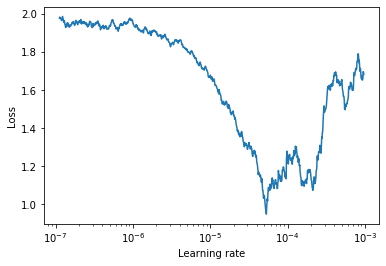

In [33]:
lr_finder.plot()

In [31]:
len(lr_finder.history['loss'])

400

In [34]:
import pandas as pd

In [42]:
lrf_df = pd.DataFrame.from_dict(lr_finder.history)
lrf_df.index = lrf_df['lr']
del lrf_df['lr']


In [46]:
lrf_df.to_csv("../lr_finder_data.csv")

AttributeError: 'Line2D' object has no property 'semilogx'

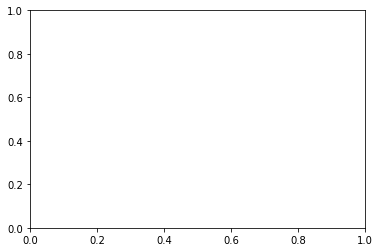

In [45]:
lrf_df.plot()